<a href="https://colab.research.google.com/github/alekrul/gt-health-management/blob/main/CMAPSS_RUL_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPASS RUL Estimation

This project aims to estimate remaining useful life (RUL) for CMAPSS Nasa Jet Engine data.

https://data.nasa.gov/Aerospace/CMAPSS-Jet-Engine-Simulated-Data/ff5v-kuh6/about_data

Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, ‘Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation’, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.

In [1]:
import math
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

sns.set()

## Import data
Data Set: FD001
Train trajectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trajectories: 260
Test trajectories: 259
Conditions: SIX
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trajectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trajectories: 248
Test trajectories: 249
Conditions: SIX
Fault Modes: TWO (HPC Degradation, Fan Degradation)


In [2]:
jet_data = pd.read_csv("/content/drive/MyDrive/Mestrado/Condition Based HM/Data/CMAPSSData/train_FD001.txt", sep=" ", header=None) #HPC Degradation
jet_rul = pd.read_csv("/content/drive/MyDrive/Mestrado/Condition Based HM/Data/CMAPSSData/RUL_FD001.txt", sep=" ", header=None)
test_data = pd.read_csv("/content/drive/MyDrive/Mestrado/Condition Based HM/Data/CMAPSSData/test_FD001.txt", sep = "\s+", header = None)
jet_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21","sensor22","sensor23"]
test_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21"]

jet_data.drop(['sensor22', 'sensor23'], axis=1, inplace=True)

jet_rul.columns = ['cycles', 'id']
jet_rul['id'] = jet_data['id'].unique()
jet_rul.set_index('id', inplace=True)

jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()
jet_id_and_rul.set_index('id', inplace=True)

In [3]:
jet_data.head()

id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
0   1      1 -0.0007 -0.0004  100.0   518.67   641.82  1589.70  1400.60   
1   1      2  0.0019 -0.0003  100.0   518.67   642.15  1591.82  1403.14   
2   1      3 -0.0043  0.0003  100.0   518.67   642.35  1587.99  1404.20   
3   1      4  0.0007  0.0000  100.0   518.67   642.35  1582.79  1401.87   
4   1      5 -0.0019 -0.0002  100.0   518.67   642.37  1582.85  1406.22   

   sensor5  ...  sensor12  sensor13  sensor14  sensor15  sensor16  sensor17  \
0    14.62  ...    521.66   2388.02   8138.62    8.4195      0.03       392   
1    14.62  ...    522.28   2388.07   8131.49    8.4318      0.03       392   
2    14.62  ...    522.42   2388.03   8133.23    8.4178      0.03       390   
3    14.62  ...    522.86   2388.08   8133.83    8.3682      0.03       392   
4    14.62  ...    522.19   2388.04   8133.80    8.4294      0.03       393   

   sensor18  sensor19  sensor20  sensor21  
0      2388     100.0     39.06   23.4190  
1      2388     100.0     39.00   23.4236  
2      2388     100.0     38.95   23.3442  
3      2388     100.0     38.88   23.3739  
4      2388     100.0     38.90   23.4044  

[5 rows x 26 columns]

In [4]:
jet_rul.head()

cycles
id        
1      112
2       98
3       69
4       82
5       91

In [5]:
jet_id_and_rul.head()

cycle
id       
1     192
2     287
3     179
4     189
5     269

1. Index Names:"engine" : Engine No."cycle" : Time, In Cycles
2. Setting Names:"setting1" : Operation Setting 1"setting2" : Operation Setting 2"setting3" : Operation Setting 3
operational conditions: altitude (O-42K ft.), Mach number
(0-0.84), and TRA (20-100).
3. Sensor Names:"sensor1" : Fan Inlet Temperature (◦R)"sensor2" : LPC Outlet Temperature (◦R)"sensor3" : HPC Outlet Temperature (◦R)"sensor4" : LPT Outlet Temperature (◦R)"sensor5" : Fan Inlet Pressure (psia)"sensor6" : Bypass-Duct Pressure (psia)"sensor7" : HPC Outlet Pressure (psia)"sensor8" : Physical Fan Speed (rpm)"sensor9" : Physical Core Speed (rpm)"sensor10" : Engine Pressure Ratio(P50/P2)"sensor11" : HPC Outlet Static Pressure (psia)"sensor12" : Ratio of Fuel Flow to Ps30 (pps/psia)"sensor13" : Corrected Fan Speed (rpm)"sensor14" : Corrected Core Speed (rpm)"sensor15" : Bypass Ratio"sensor16" : Burner Fuel-Air Ratio"sensor17" : Bleed Enthalpy"sensor18" : Required Fan Speed"sensor19" : Required Fan Conversion Speed"sensor20" : High-Pressure Turbines Cool Air Flow"sensor21" : Low-Pressure Turbines Cool Air Flow

In [6]:
#add RUL column to test data
def RUL_calculator(df, df_max_cycles):
    max_cycle = df_max_cycles["cycle"]
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='id', right_index=True)
    result_frame["RUL"] = result_frame["max_cycle"] - result_frame["cycle"]
    result_frame.drop(['max_cycle'], axis=1, inplace=True)
    return result_frame

jet_data = RUL_calculator(jet_data, jet_id_and_rul)

In [7]:
jet_data.head()

id  cycle     op1     op2    op3  sensor1  sensor2  sensor3  sensor4  \
0   1      1 -0.0007 -0.0004  100.0   518.67   641.82  1589.70  1400.60   
1   1      2  0.0019 -0.0003  100.0   518.67   642.15  1591.82  1403.14   
2   1      3 -0.0043  0.0003  100.0   518.67   642.35  1587.99  1404.20   
3   1      4  0.0007  0.0000  100.0   518.67   642.35  1582.79  1401.87   
4   1      5 -0.0019 -0.0002  100.0   518.67   642.37  1582.85  1406.22   

   sensor5  ...  sensor13  sensor14  sensor15  sensor16  sensor17  sensor18  \
0    14.62  ...   2388.02   8138.62    8.4195      0.03       392      2388   
1    14.62  ...   2388.07   8131.49    8.4318      0.03       392      2388   
2    14.62  ...   2388.03   8133.23    8.4178      0.03       390      2388   
3    14.62  ...   2388.08   8133.83    8.3682      0.03       392      2388   
4    14.62  ...   2388.04   8133.80    8.4294      0.03       393      2388   

   sensor19  sensor20  sensor21  RUL  
0     100.0     39.06   23.4190  191  
1     100.0     39.00   23.4236  190  
2     100.0     38.95   23.3442  189  
3     100.0     38.88   23.3739  188  
4     100.0     38.90   23.4044  187  

[5 rows x 27 columns]

## Data analysis and visualization

In [8]:
jet_data.describe()

id         cycle           op1           op2      op3  \
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.0   
mean      51.506568    108.807862     -0.000009      0.000002    100.0   
std       29.227633     68.880990      0.002187      0.000293      0.0   
min        1.000000      1.000000     -0.008700     -0.000600    100.0   
25%       26.000000     52.000000     -0.001500     -0.000200    100.0   
50%       52.000000    104.000000      0.000000      0.000000    100.0   
75%       77.000000    156.000000      0.001500      0.000300    100.0   
max      100.000000    362.000000      0.008700      0.000600    100.0   

            sensor1       sensor2       sensor3       sensor4       sensor5  \
count  2.063100e+04  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   5.186700e+02    642.680934   1590.523119   1408.933782  1.462000e+01   
std    6.537152e-11      0.500053      6.131150      9.000605  3.394700e-12   
min    5.186700e+02    641.210000   1571.040000   1382.250000  1.462000e+01   
25%    5.186700e+02    642.325000   1586.260000   1402.360000  1.462000e+01   
50%    5.186700e+02    642.640000   1590.100000   1408.040000  1.462000e+01   
75%    5.186700e+02    643.000000   1594.380000   1414.555000  1.462000e+01   
max    5.186700e+02    644.530000   1616.910000   1441.490000  1.462000e+01   

       ...      sensor13      sensor14      sensor15      sensor16  \
count  ...  20631.000000  20631.000000  20631.000000  2.063100e+04   
mean   ...   2388.096152   8143.752722      8.442146  3.000000e-02   
std    ...      0.071919     19.076176      0.037505  1.556432e-14   
min    ...   2387.880000   8099.940000      8.324900  3.000000e-02   
25%    ...   2388.040000   8133.245000      8.414900  3.000000e-02   
50%    ...   2388.090000   8140.540000      8.438900  3.000000e-02   
75%    ...   2388.140000   8148.310000      8.465600  3.000000e-02   
max    ...   2388.560000   8293.720000      8.584800  3.000000e-02   

           sensor17  sensor18  sensor19      sensor20      sensor21  \
count  20631.000000   20631.0   20631.0  20631.000000  20631.000000   
mean     393.210654    2388.0     100.0     38.816271     23.289705   
std        1.548763       0.0       0.0      0.180746      0.108251   
min      388.000000    2388.0     100.0     38.140000     22.894200   
25%      392.000000    2388.0     100.0     38.700000     23.221800   
50%      393.000000    2388.0     100.0     38.830000     23.297900   
75%      394.000000    2388.0     100.0     38.950000     23.366800   
max      400.000000    2388.0     100.0     39.430000     23.618400   

                RUL  
count  20631.000000  
mean     107.807862  
std       68.880990  
min        0.000000  
25%       51.000000  
50%      103.000000  
75%      155.000000  
max      361.000000  

[8 rows x 27 columns]

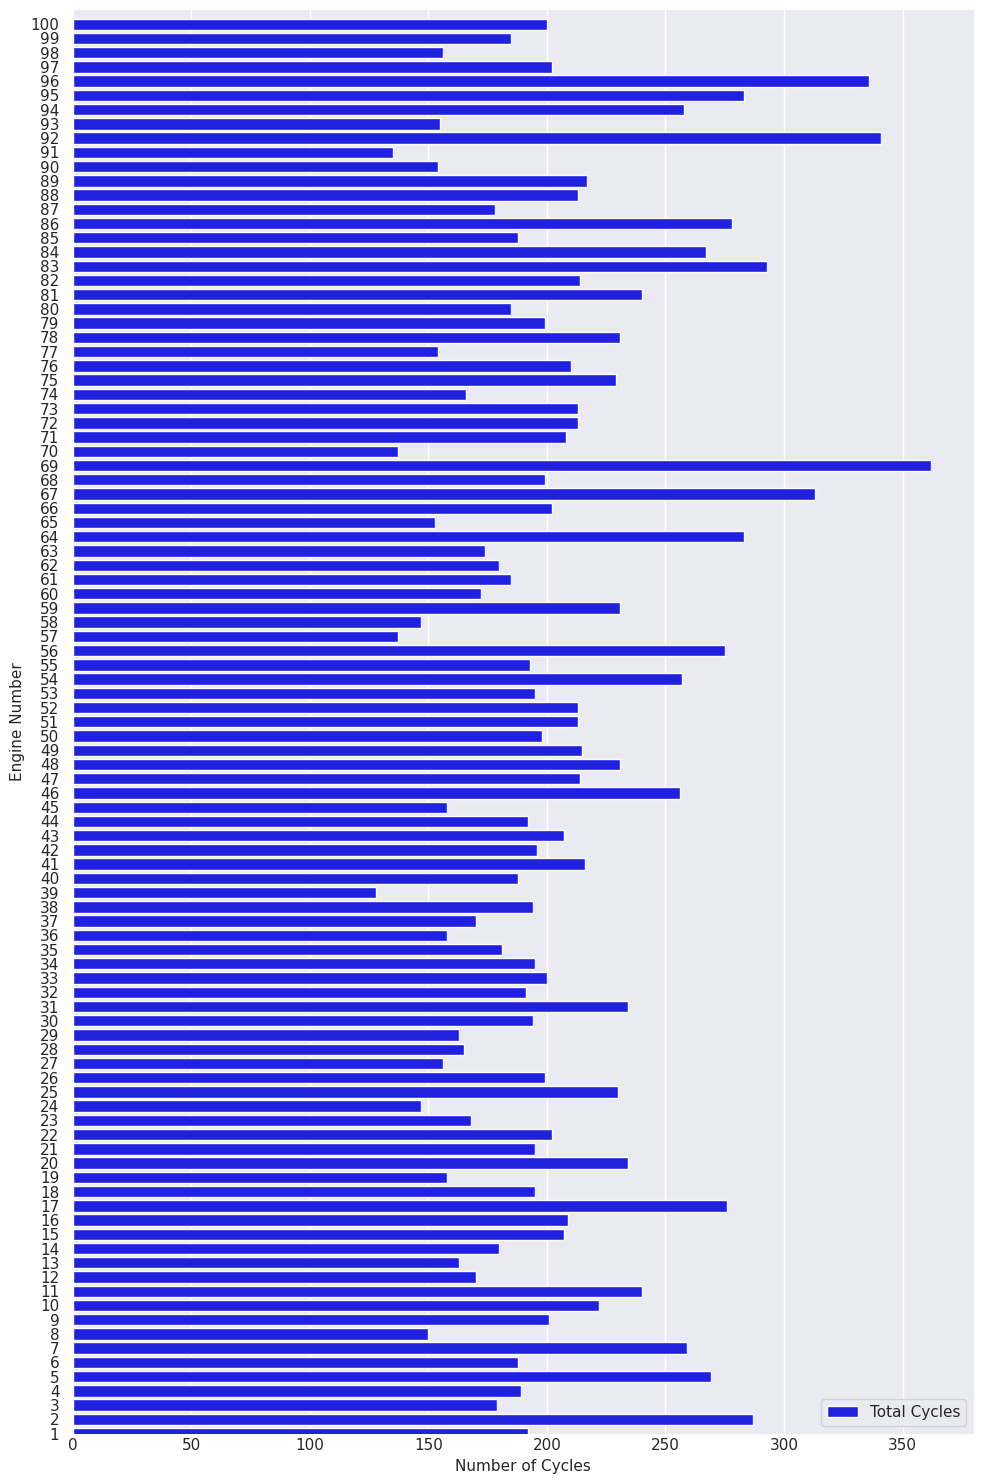

In [9]:
jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="cycle", y="id", data=jet_id_and_rul, label="Total Cycles", color="blue", orient = 'h', dodge=False)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0, 100), ylabel="",xlabel="Lifetime for each engine")
sns.despine(left=True, bottom=True)
ax.tick_params(labelsize=11)
ax.tick_params(length=0, axis='x')
ax.set_ylabel("Engine Number", fontsize=11)
ax.set_xlabel("Number of Cycles", fontsize=11)
plt.tight_layout()
plt.show()

Mean number of cycles after which jet engine fails is 206


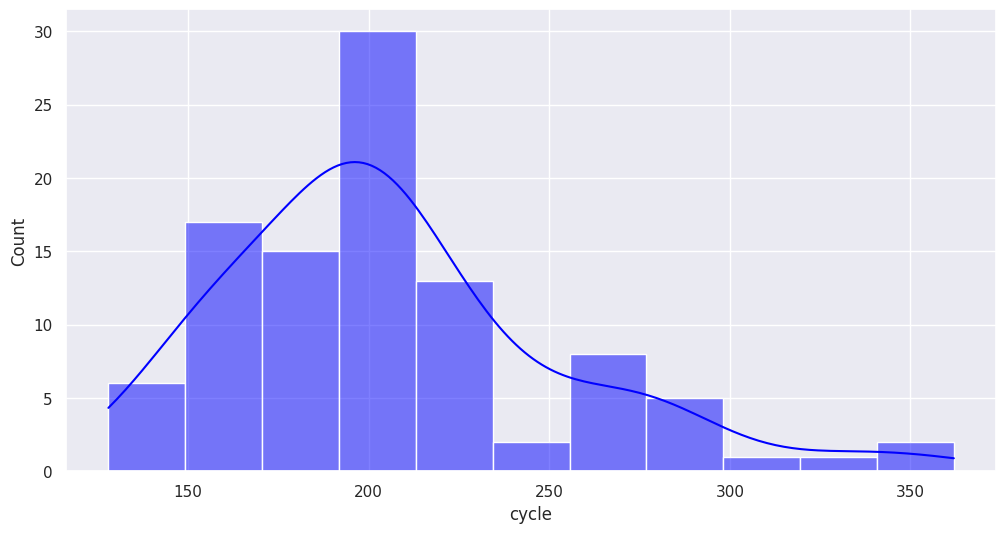

In [10]:
plt.subplots(figsize=(12, 6))
sns.histplot(jet_id_and_rul["cycle"], kde = True, color='blue');
print("Mean number of cycles after which jet engine fails is "+ str(math.floor(jet_id_and_rul["cycle"].mean())))

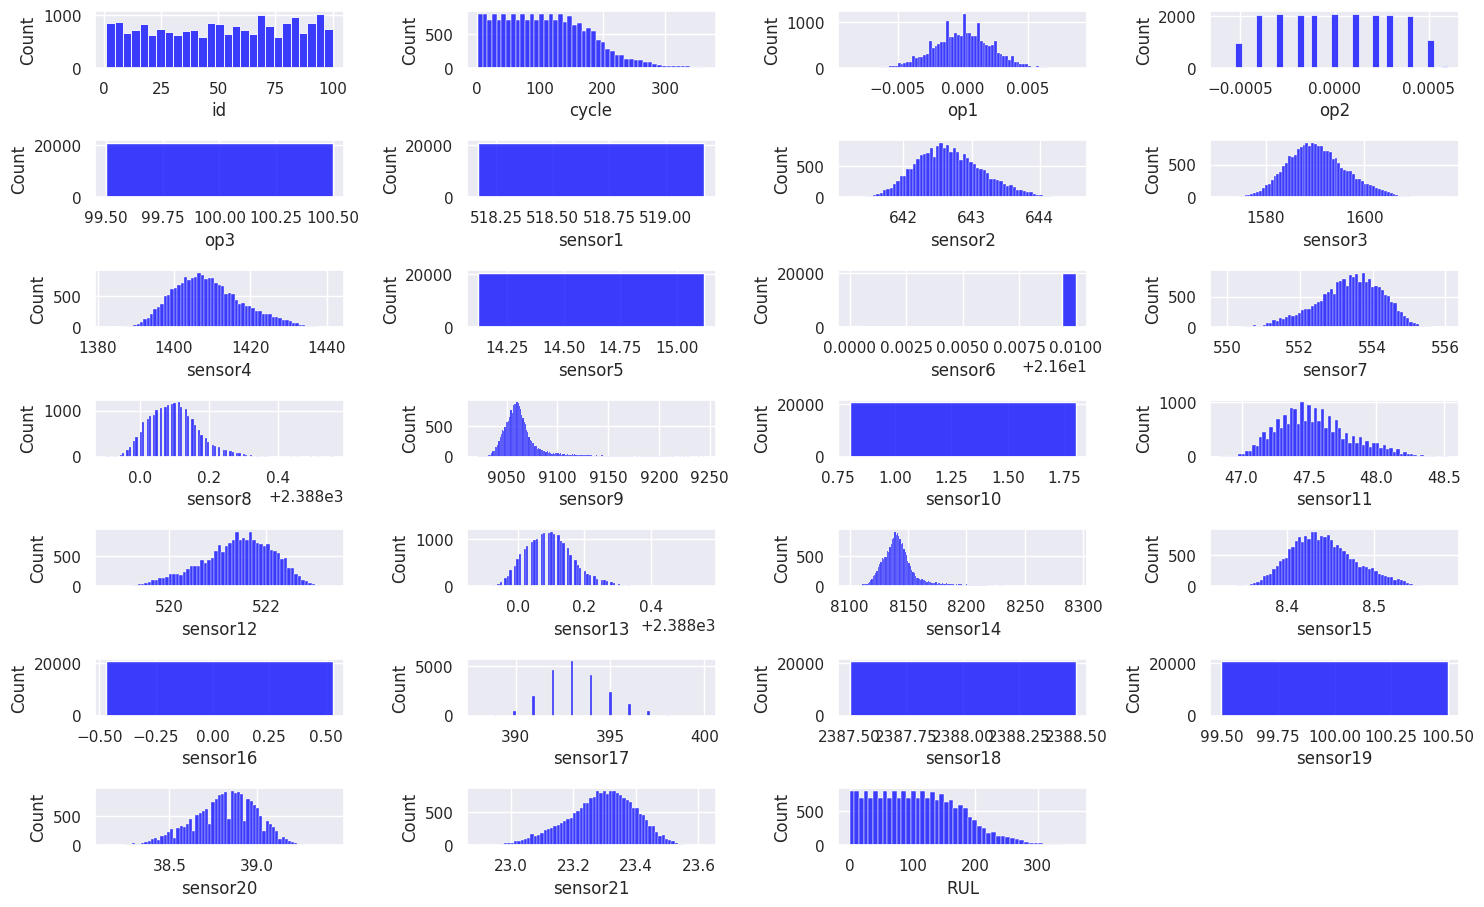

In [11]:
#Histogram representation of each sensor data

sns.set()
fig = plt.figure(figsize = [15,10])
cols = jet_data.columns
cnt = 1
for col in cols :
    plt.subplot(8,4,cnt)
    sns.histplot(jet_data[col],color='blue')
    cnt+=1
plt.tight_layout()
plt.show()

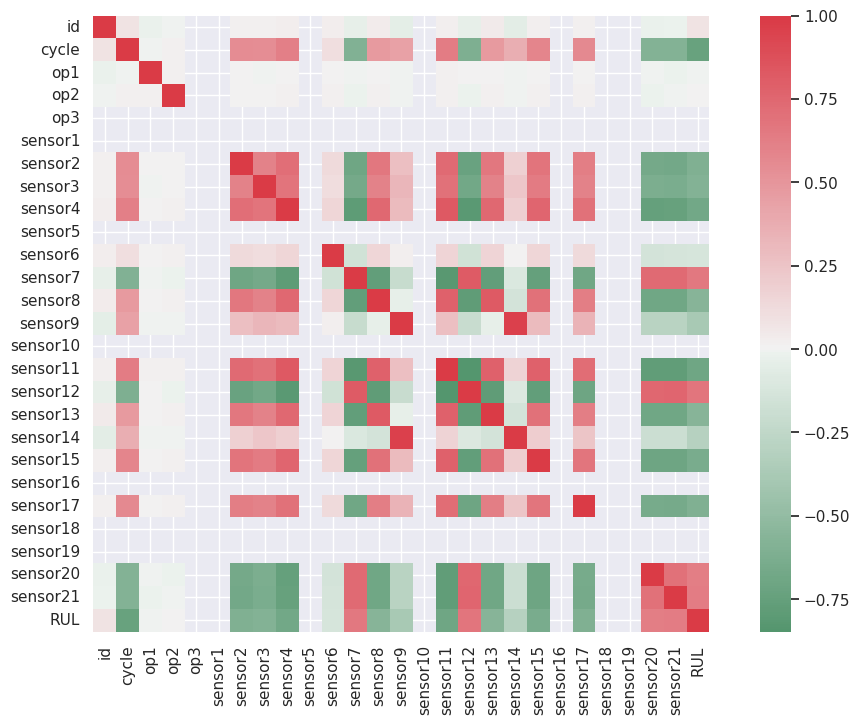

In [12]:
plt.figure(figsize=(13,8))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_data.corr(), cmap =cmap, center=0, annot=False, square=True);

In [13]:
jet_relevant_data = jet_data.drop(["cycle", "op1", "op2", "op3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19", "sensor14", "sensor13", "sensor12", "sensor11"], axis=1)

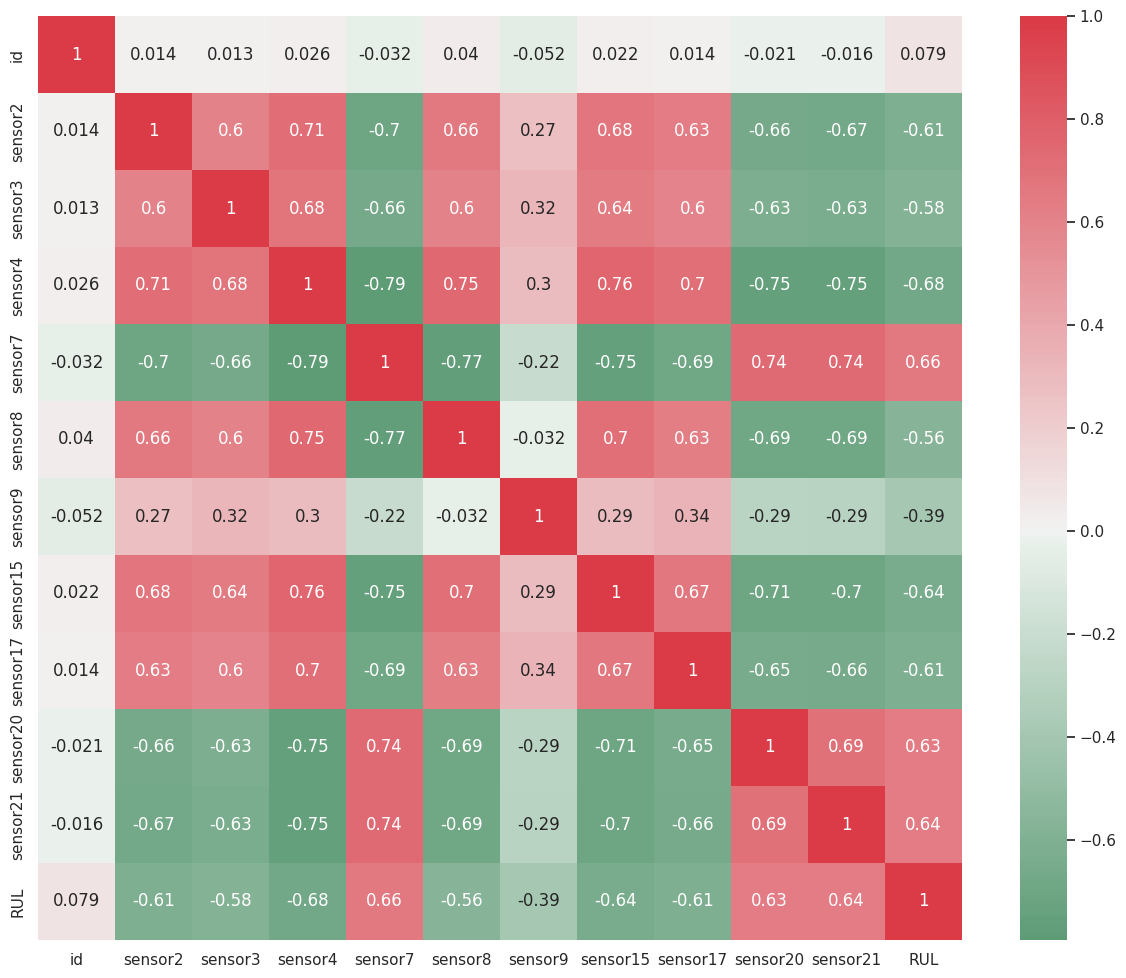

In [14]:
plt.figure(figsize=(15, 12))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_relevant_data.corr(), cmap =cmap, center=0, annot=True, square=True);

In [15]:
def plot_sensor(sensor_name,X):
    plt.figure(figsize=(13,5))
    for i in X['id'].unique():
        if (i % 10 == 0):  # only plot every engine
            plt.plot('RUL', sensor_name,
                     data=X[X['id']==i].rolling(8).mean())
            plt.axvline(30, color='red', linestyle='dashed', linewidth=2)
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

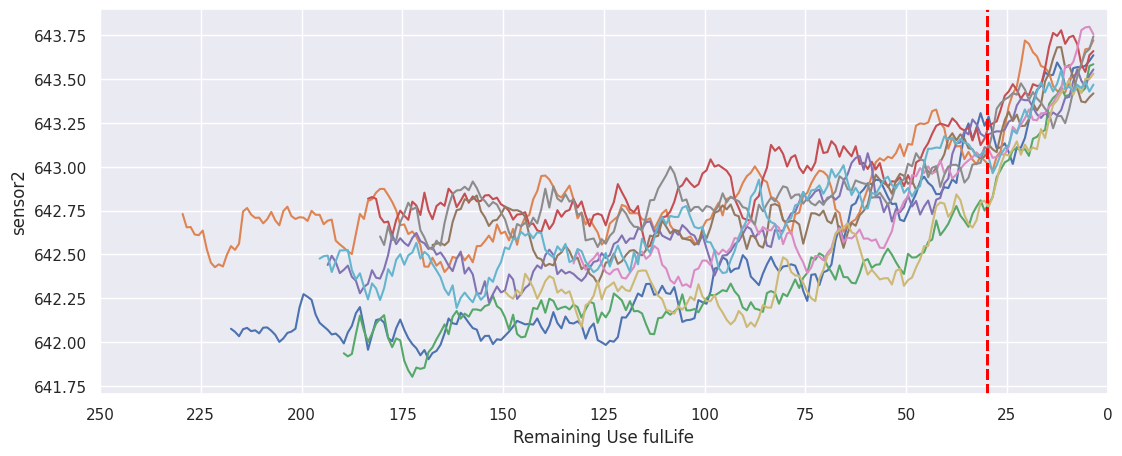

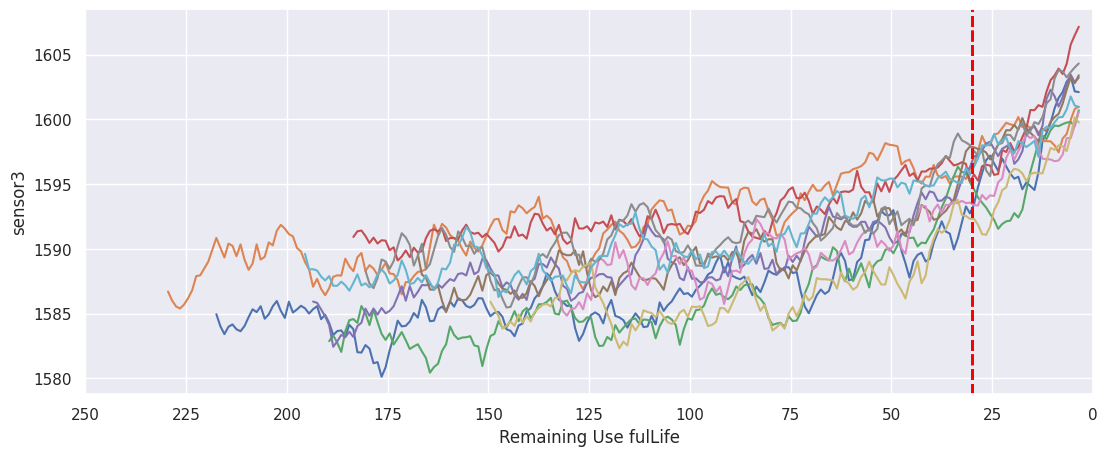

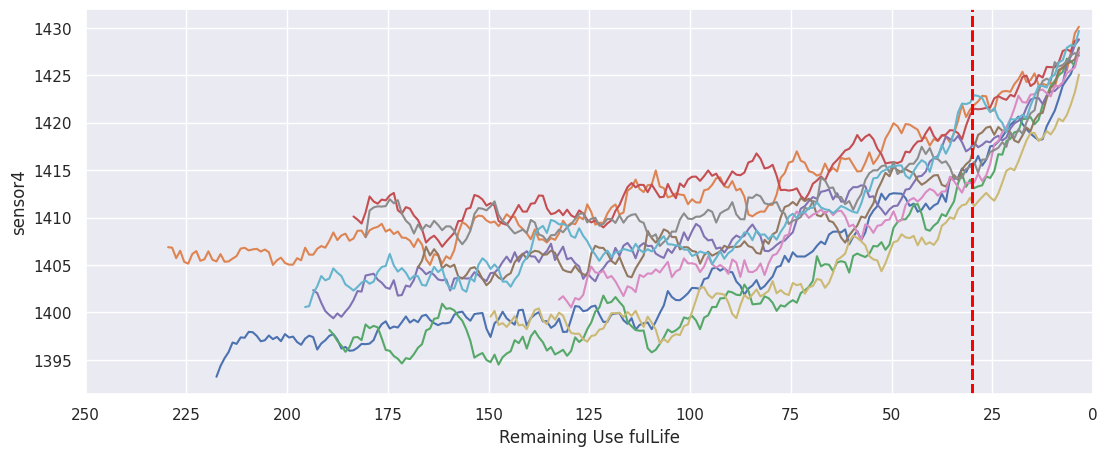

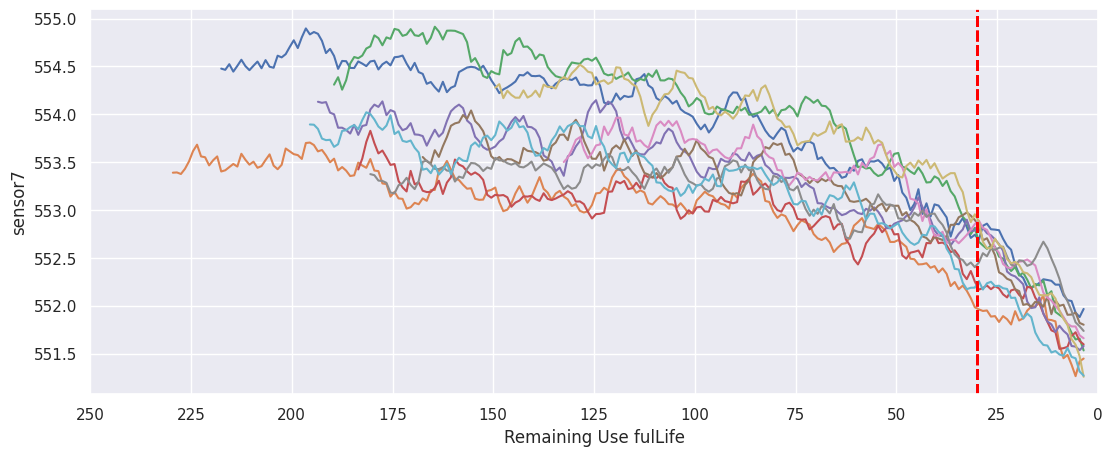

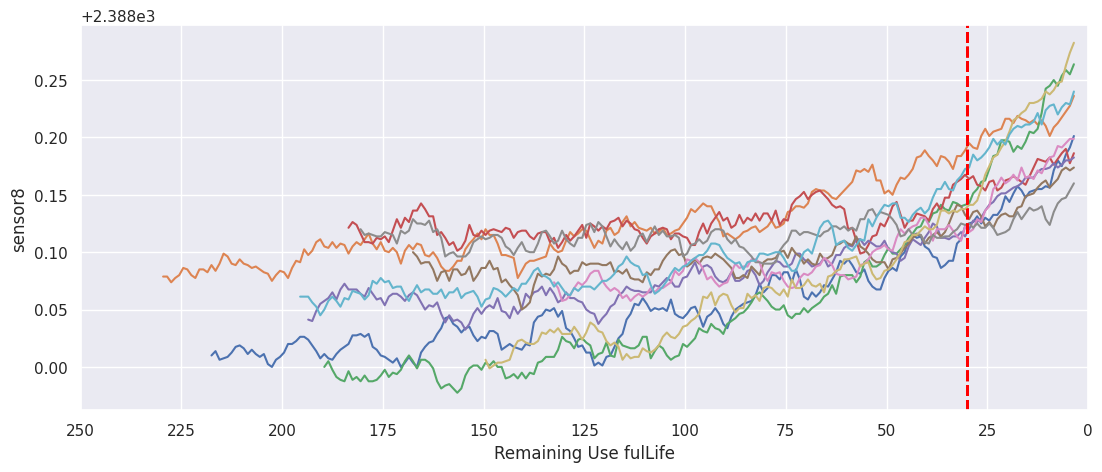

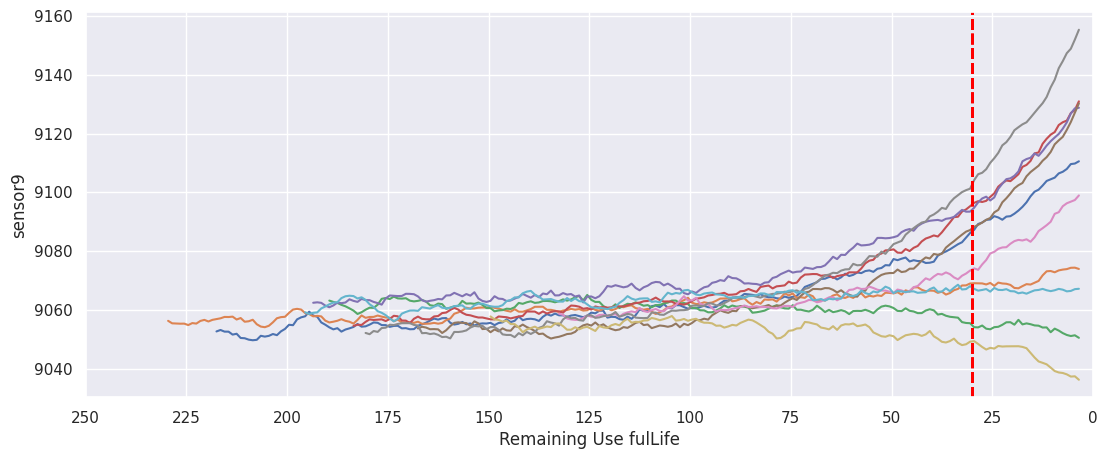

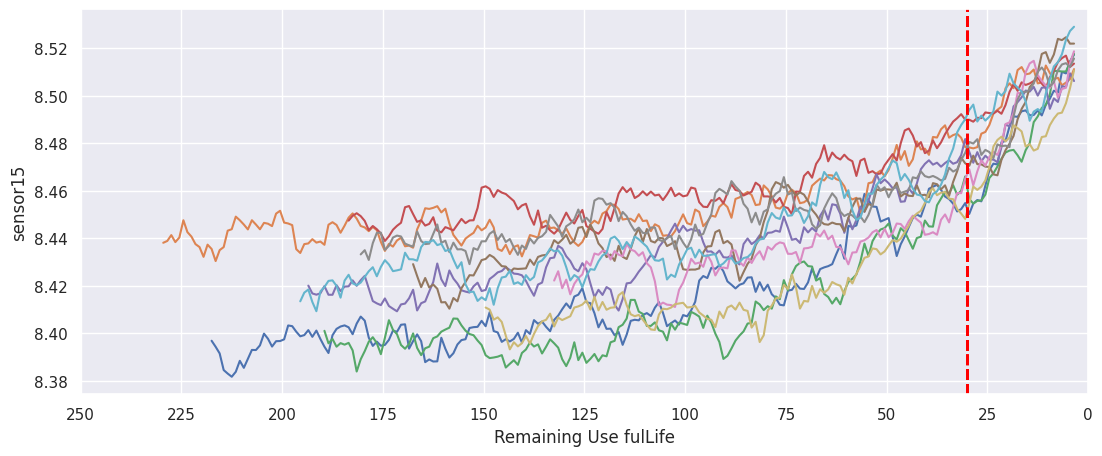

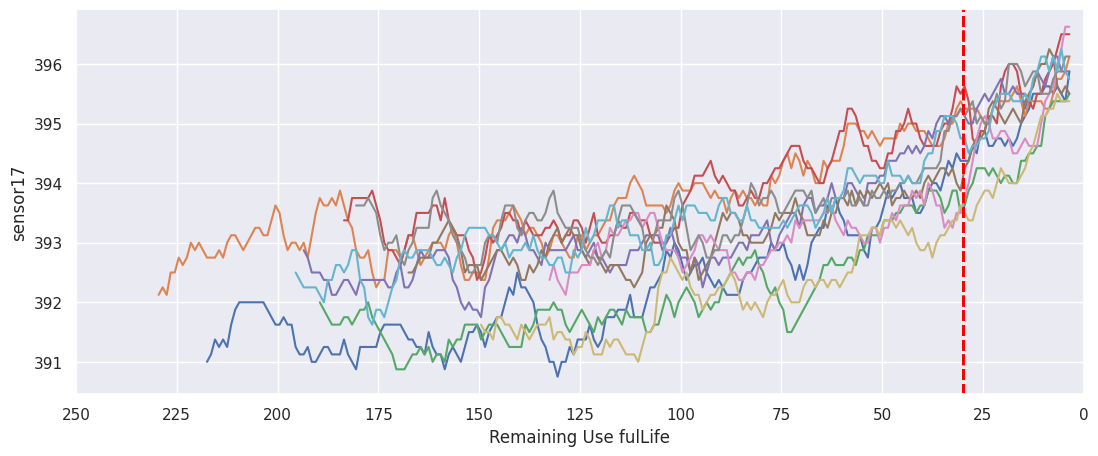

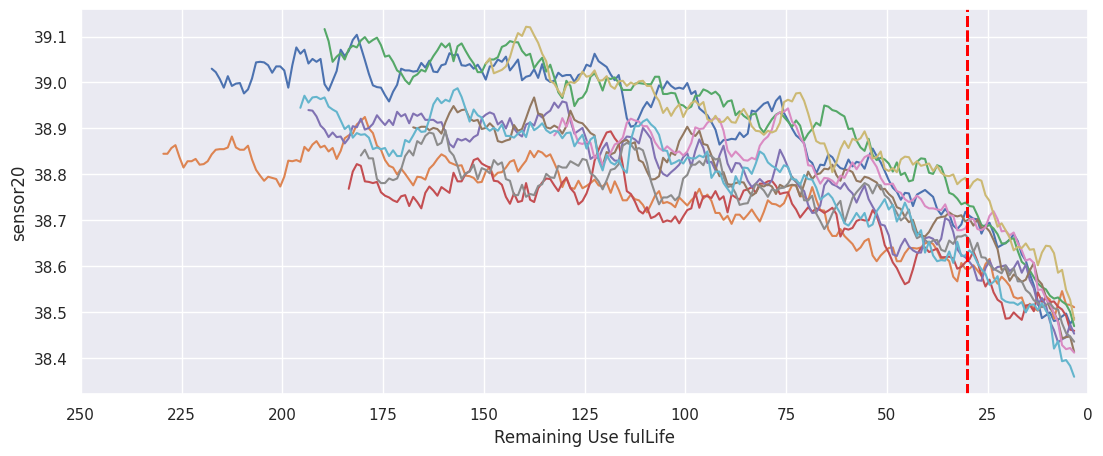

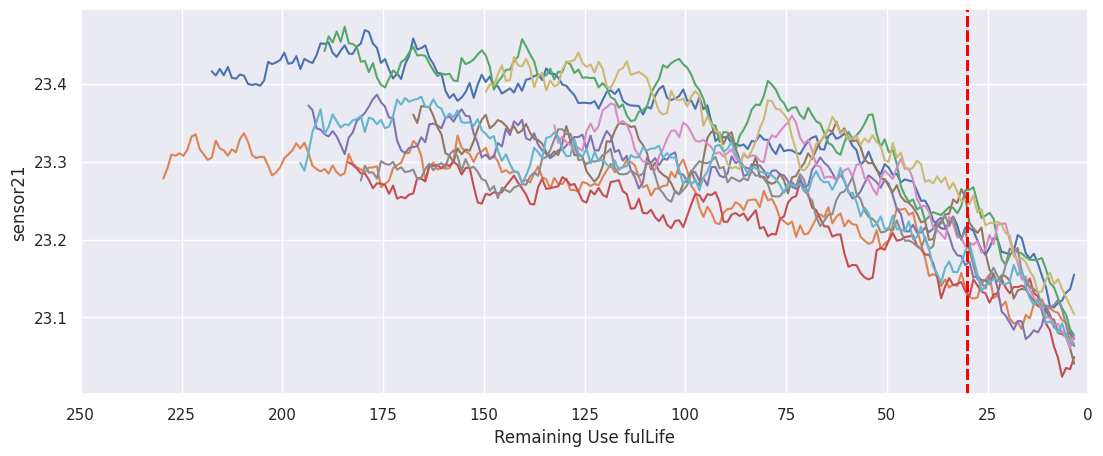

In [16]:
for sensor in jet_relevant_data.drop(['id', 'RUL'], axis=1).columns:
    plot_sensor(sensor, jet_relevant_data)

In [17]:
jet_relevant_data.drop('sensor9', axis=1, inplace=True)

In [18]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(jet_relevant_data.drop(['id', 'RUL'], axis=1))
scaled_features = pd.DataFrame(scaled_features, columns=jet_relevant_data.drop(['id', 'RUL'], axis=1).columns)

In [19]:
scaled_features['id'] = jet_relevant_data['id']
scaled_features['RUL'] = jet_relevant_data['RUL']

In [20]:
scaled_features.head()

sensor2   sensor3   sensor4   sensor7   sensor8  sensor15  sensor17  \
0  0.183735  0.406802  0.309757  0.726248  0.242424  0.363986  0.333333   
1  0.283133  0.453019  0.352633  0.628019  0.212121  0.411312  0.333333   
2  0.343373  0.369523  0.370527  0.710145  0.272727  0.357445  0.166667   
3  0.343373  0.256159  0.331195  0.740741  0.318182  0.166603  0.333333   
4  0.349398  0.257467  0.404625  0.668277  0.242424  0.402078  0.416667   

   sensor20  sensor21  id  RUL  
0  0.713178  0.724662   1  191  
1  0.666667  0.731014   1  190  
2  0.627907  0.621375   1  189  
3  0.573643  0.662386   1  188  
4  0.589147  0.704502   1  187

In [21]:
data = scaled_features.copy()

In [22]:
cycle=30
data['label'] = data['RUL'].apply(lambda x: 1 if x <= cycle else 0)

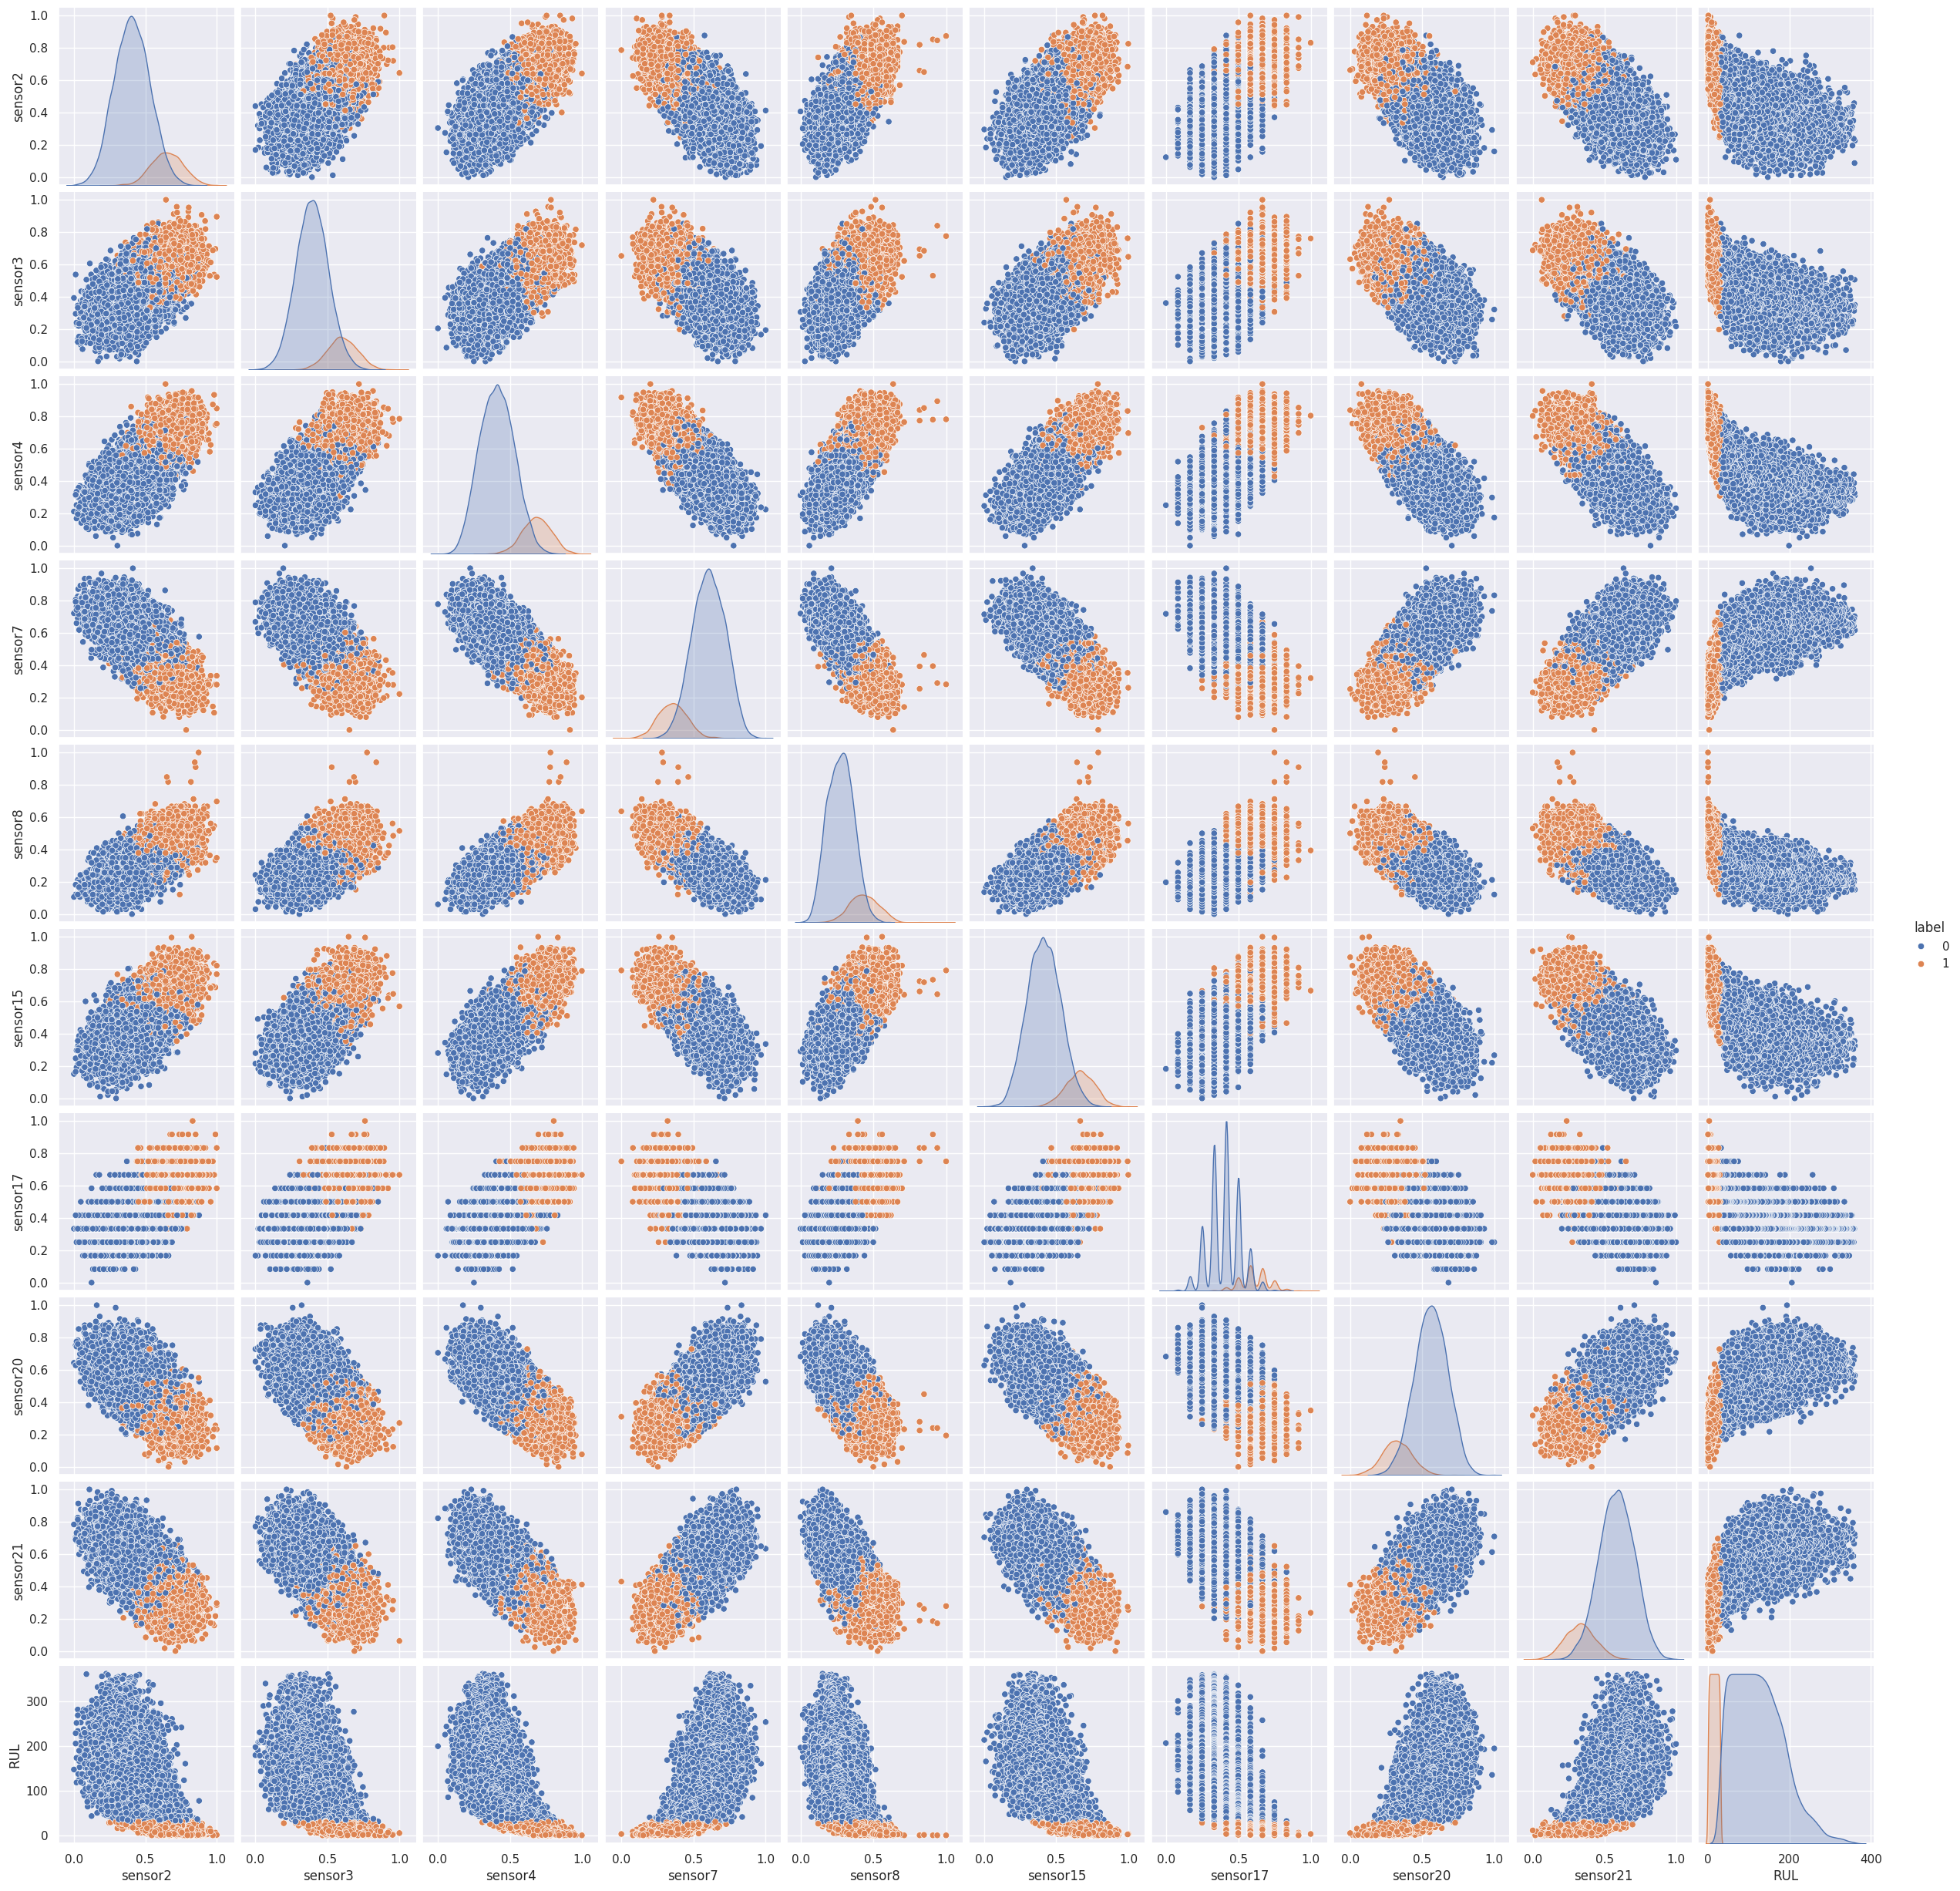

In [23]:
sns.pairplot(data.drop(['id'], axis=1), hue="label")

In [24]:
y = data['label']
X = data.drop(['RUL', 'id', 'label'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)

print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (16504, 9)
X_test shape :  (4127, 9)
y_train shape :  (16504,)
y_test shape :  (4127,)


In [25]:
classifier = RandomForestClassifier(random_state=90, oob_score = False)

# Define the parameter Grid
params = {
 'max_depth': [18, 20, 22],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [22, 25],
 'min_samples_leaf': [12, 10, 8],
 'n_estimators': [20, 30, 40]
}
# Initialize the Grid Search with accuracy metrics
grid_search = GridSearchCV(estimator=classifier,
                                  param_grid=params,
                                  cv = 5,
                                  scoring="f1")
# Fitting 5 Folds for each of 108 candidates, total 540 fits
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
# Let's check the score
grid_search.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
270 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

0.825246905144313

In [26]:
grid_search.best_params_

{'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 25,
 'n_estimators': 20}

In [27]:
pred = grid_search.predict(X_test)
print('Acc Score: ',accuracy_score(y_test, pred))
print('Roc Auc Score: ',roc_auc_score(y_test, pred))
print('Precision Score: ',precision_score(y_test, pred))
print('Recall Score: ',recall_score(y_test, pred))
print('f1 score: ',f1_score(y_test, pred))

Acc Score:  0.9493578870850496
Roc Auc Score:  0.8842368642853764
Precision Score:  0.8571428571428571
Recall Score:  0.7915309446254072
f1 score:  0.8230313293818797


<Figure size 1500x800 with 0 Axes>

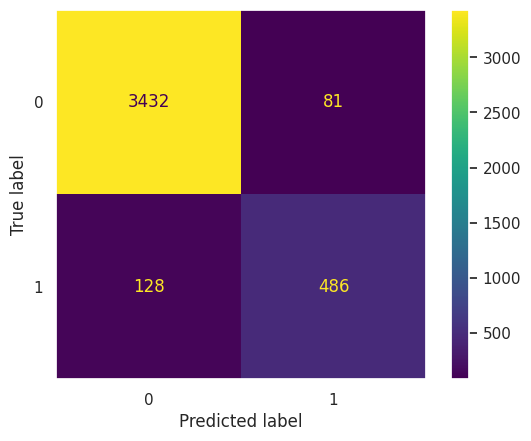

In [28]:
plt.figure(figsize=(15,8))

cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(False)
plt.show()

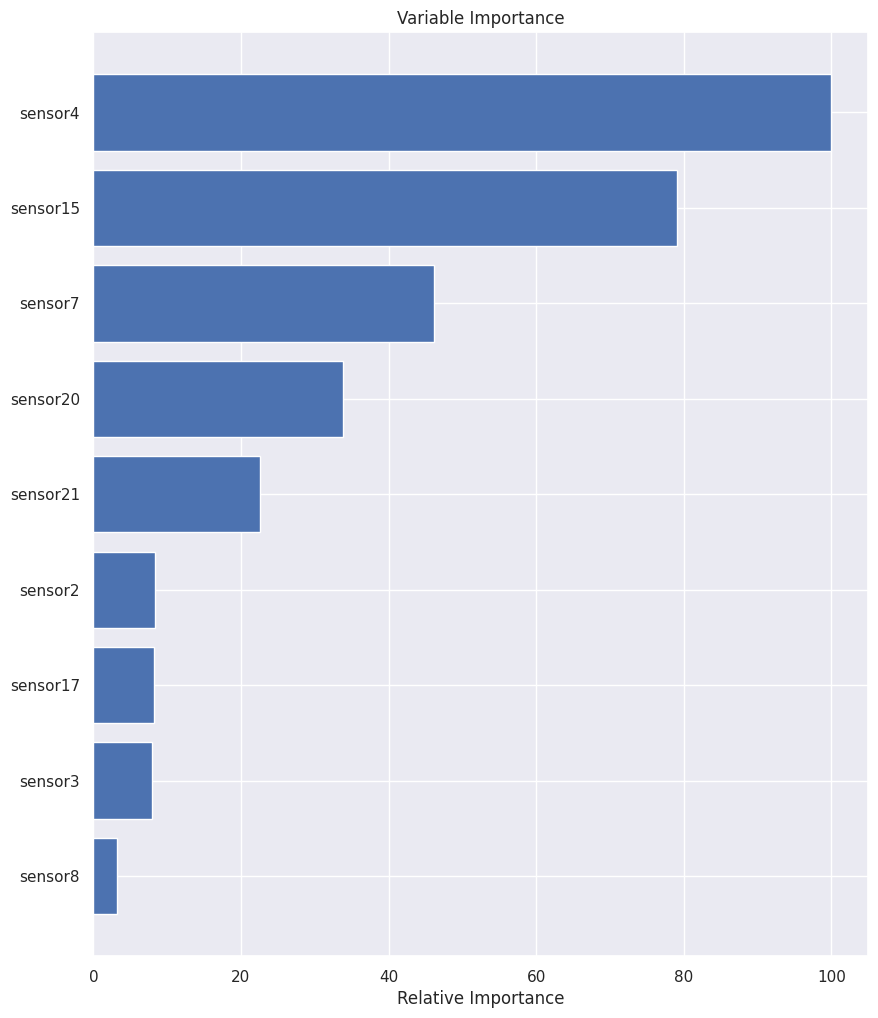

In [29]:
best_model = grid_search.best_estimator_

# Plotting the Relative Importance as per tuned model
feature_importance = best_model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 50:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [30]:
lr_classifier = LogisticRegression()

# Define the parameter Grid
params = {
 'solver': ['newton-cg', 'lbfgs', 'liblinear'],
 'penalty': ['l2'],
 'C': [1.2, 1.5, 1.8]
}
# Initialize the Grid Search with accuracy metrics
grid_search = GridSearchCV(estimator=lr_classifier,
                                  param_grid=params,
                                  cv = 5,
                                  scoring="f1")
# Fitting 5 Folds for each of 108 candidates, total 540 fits
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
# Let's check the score
grid_search.best_score_

0.8280756062611381

In [31]:
pred = grid_search.predict(X_test)

print('Acc Score: ',accuracy_score(y_test, pred))
print('Roc Auc Score: ',roc_auc_score(y_test, pred))
print('Precision Score: ',precision_score(y_test, pred))
print('Recall Score: ',recall_score(y_test, pred))
print('f1 score: ',f1_score(y_test, pred))

Acc Score:  0.9486309668039739
Roc Auc Score:  0.8817938675427055
Precision Score:  0.8563829787234043
Recall Score:  0.7866449511400652
f1 score:  0.8200339558573854


<Figure size 1500x800 with 0 Axes>

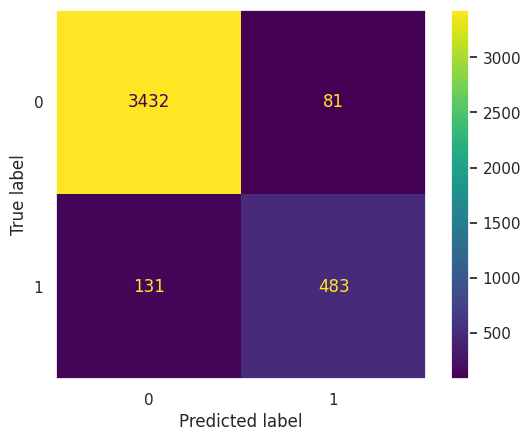

In [32]:
plt.figure(figsize=(15,8))

cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(False)
plt.show()

##LGBMClassifier

In [34]:
import lightgbm as lgb
lgb_clss = lgb.LGBMClassifier(learning_rate=0.01,n_estimators=5000,num_leaves=100,objective='binary', metrics='auc',random_state=50,n_jobs=-1)
lgb_clss.fit(X_train, y_train)
lgb_clss.score(X_test, y_test)
preds2 = lgb_clss.predict(X_test)
print('Acc Score: ',accuracy_score(y_test, preds2))
print('Roc Auc Score: ',roc_auc_score(y_test, preds2))
print('Precision Score: ',precision_score(y_test, preds2))
print('Recall Score: ',recall_score(y_test, preds2))
print('f1 score: ',f1_score(y_test, preds2,average='binary'))

[LightGBM] [Info] Number of positive: 2486, number of negative: 14018
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 16504, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.150630 -> initscore=-1.729667
[LightGBM] [Info] Start training from score -1.729667
Acc Score:  0.9433002180760843
Roc Auc Score:  0.8692545881235912
Precision Score:  0.8405017921146953
Recall Score:  0.7638436482084691
f1 score:  0.8003412969283277


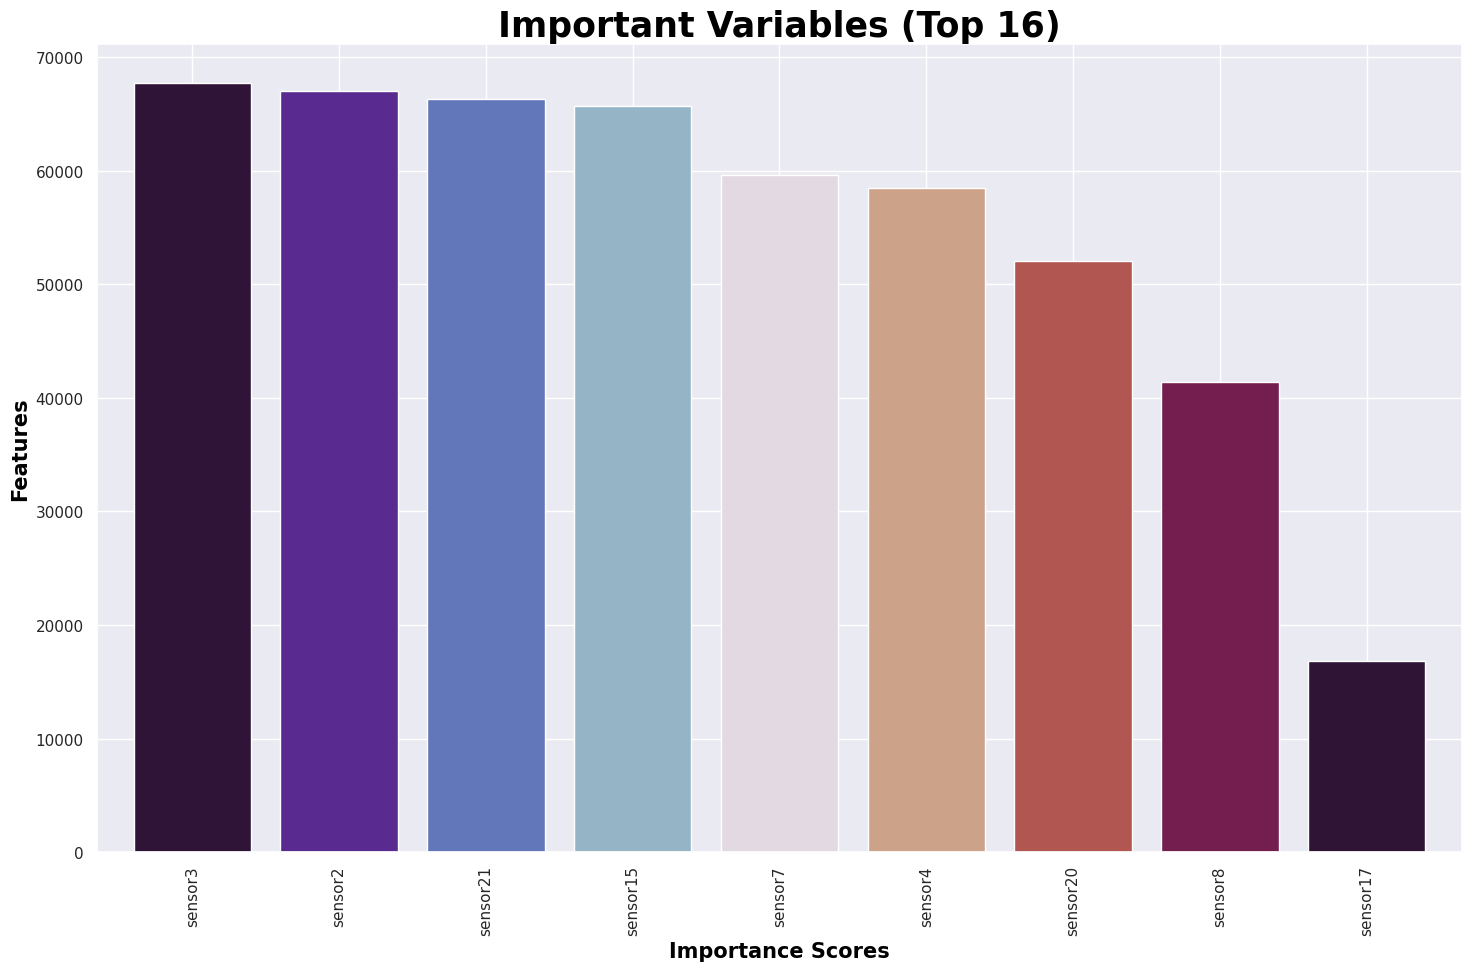

In [38]:
colors = [plt.cm.twilight_shifted(i / float(len(X.columns) - 1)) for i in range(len(X.columns))]
columns_X_train = X.columns.tolist()

# Ensure X_train has correct column names
X_train = pd.DataFrame(X_train)
X_train.columns = columns_X_train

# Feature importances
feat_importances = pd.Series(lgb_clss.feature_importances_, index=X_train.columns)

# Plot feature importances
plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 16})
plt.title('Important Variables (Top 16)', color='black', fontweight='bold', size=25)
feat_importances.nlargest(16).plot(kind='bar', color=colors, width=0.8, align='center')
plt.ylabel('Features', color='black', fontweight='bold', size=15)
plt.xlabel('Importance Scores', color='black', fontweight='bold', size=15)
plt.tight_layout()
plt.grid(True)
plt.show()

Text(0, 0.5, 'Variables')

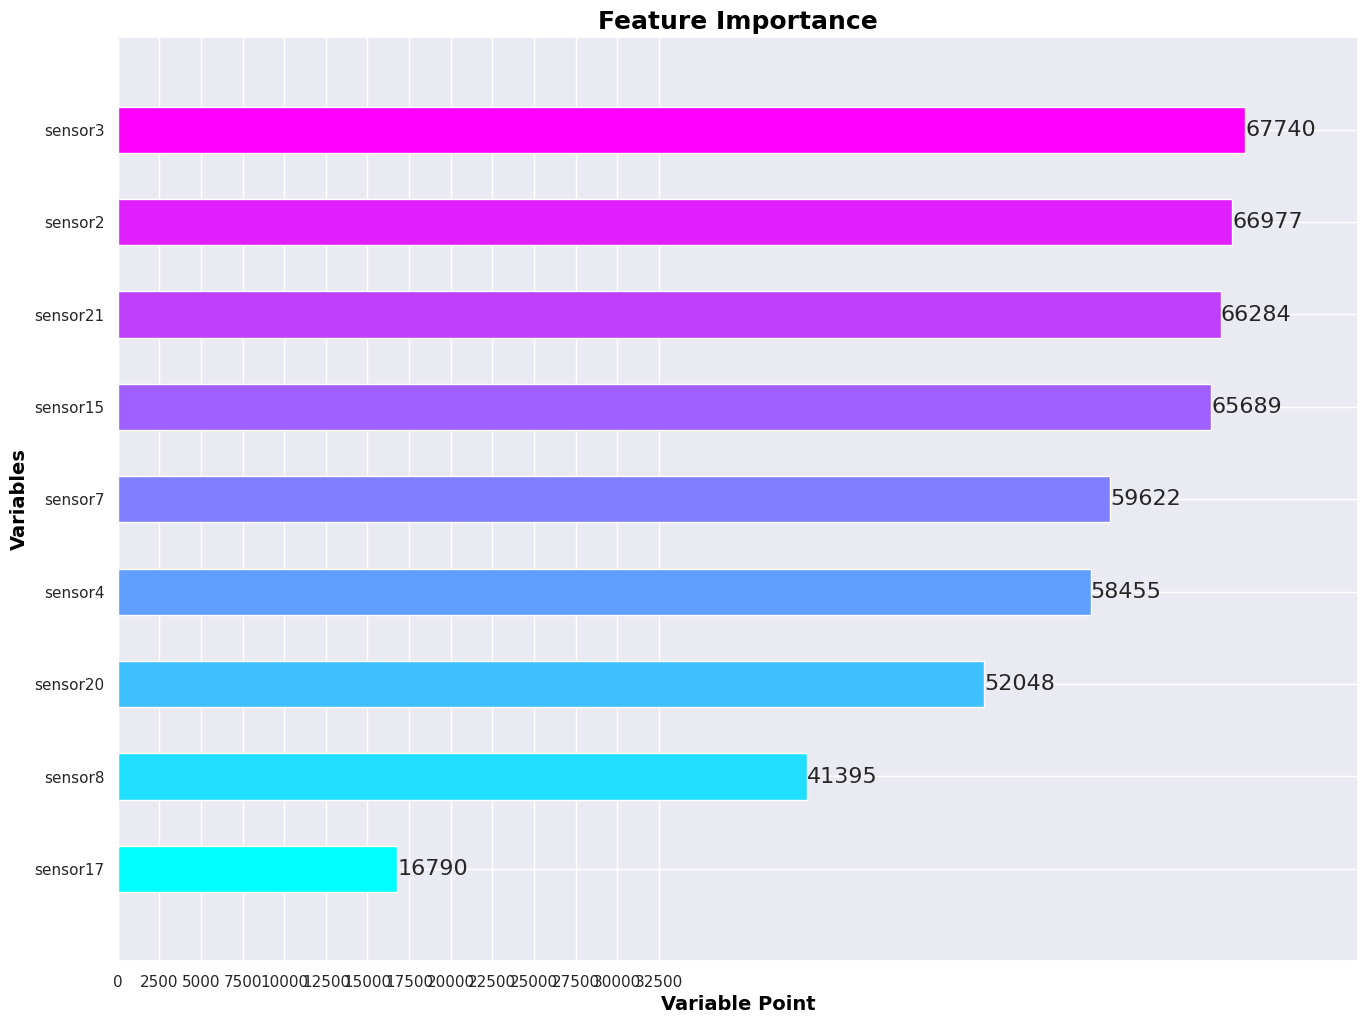

In [40]:
colors = [plt.cm.cool(i/float(len(X.columns)-1)) for i in range(len(X.columns))]
ax = lgb.plot_importance(lgb_clss, max_num_features=16,figsize=(16,12),height=0.5,color=colors)
ax.set_title('Feature Importance',color='black',fontweight='bold',size=18)
ax.set_xlabel('Variable Point',color='black',fontweight='bold',size=14)
ax.set_xticks(np.arange(0,32501,2500))
ax.set_ylabel('Variables',color='black',fontweight='bold',size=14)

##RandomizedSearchCV

In [41]:
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
stf_kf=StratifiedKFold(n_splits=5)
import xgboost as xgb
xgb_classifier=xgb.XGBClassifier(n_estimators=725,n_jobs=-1)
params={
         'learning_rate': np.arange(0.01, 0.11, 0.025),
         'max_depth': np.arange(1, 10, 1),
         'min_child_weight': np.arange(1, 10, 1),
         'subsample': np.arange( 0.7, 1, 0.05),
         'gamma': np.arange(0.5, 1, 0.1),
         'colsample_bytree': np.arange( 0.1, 1, 0.05),
         'scale_pos_weight': np.arange( 20, 200, 10)}
rs_cv_classifier=RandomizedSearchCV(xgb_classifier,param_distributions=params,cv=stf_kf,n_jobs=-1)
rs_cv_classifier.fit(X_train,y_train)
y_pred=rs_cv_classifier.predict(X_test)
print("Best Parameter: \n",rs_cv_classifier.best_params_)
print("XGBClassifier Acc Score: ",accuracy_score(y_pred,y_test))

Best Parameter: 
 {'subsample': 0.8, 'scale_pos_weight': 80, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.085, 'gamma': 0.5, 'colsample_bytree': 0.7500000000000002}
XGBClassifier Acc Score:  0.9321541070995881


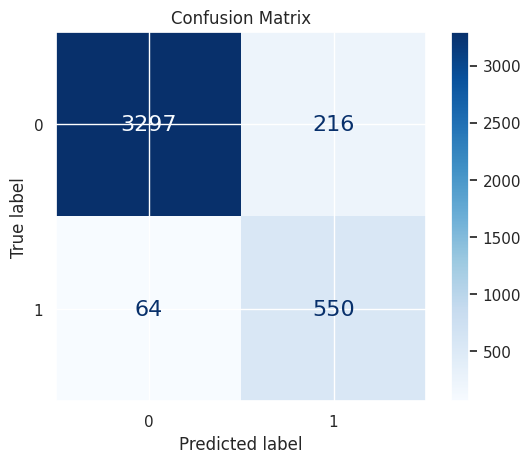

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rs_cv_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
